Generalising the LEP vs shower exploration to work on any two variables.

In [28]:
import logging

import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../..'))
sys.path.append(root_dir)

import numpy as np
import pandas as pd

from importlib import reload

from memory import garbage_collect

log = lambda msg: logging.info(msg)


# Load data

In [29]:
from sleep_events import load_days_data

day_data = load_days_data(True)

In [30]:
[c for c in day_data.columns if 'LEP' in c]

['circadian:basic:entries:LEP:temp',
 'circadian:basic:entries:LEP:datetimeSSM',
 'circadian:basic:entries:LEP:prominence',
 'circadian:combined:entries:LEP:temp',
 'circadian:combined:entries:LEP:datetimeSSM',
 'circadian:combined:entries:LEP:prominence',
 'circadian:combined:entries:LEP:minsSinceReadyToSleep',
 'circadian:combined:entries:LEP:minsUntilWake',
 'circadian:combined:entries:LEP:minsSinceSleep',
 'circadian:combined:entries:LEP:minsSinceSunsetEnd',
 'circadian:combined:entries:LEP:minsSinceSunriseEnd',
 'circadian:basic:entries:LEP:temp:vsDayMinus1',
 'circadian:basic:entries:LEP:temp:onDayMinus1',
 'circadian:basic:entries:LEP:datetimeSSM:vsDayMinus1',
 'circadian:basic:entries:LEP:datetimeSSM:onDayMinus1',
 'circadian:basic:entries:LEP:prominence:vsDayMinus1',
 'circadian:basic:entries:LEP:prominence:onDayMinus1',
 'circadian:combined:entries:LEP:temp:vsDayMinus1',
 'circadian:combined:entries:LEP:temp:onDayMinus1',
 'circadian:combined:entries:LEP:datetimeSSM:vsDayMinu

In [48]:
col1 = 'exercise:fitbit:steps'
col2 = 'night:yasa:adjusted:deepSleepSecs'

columns_to_select = [col1, col2]

df = day_data.copy()[columns_to_select]
df.index = day_data['dayAndNightOf']
import notebooks.Util.Time as Time
reload(Time)
df = Time.convert_cols_to_hours(df)

c1 = Time.convert_col_name(col1)
c2 = Time.convert_col_name(col2)
df = df[df[c1].notna() & df[c2].notna()]
df['Diff'] = df[c2] - df[c1]

df_orig = df.copy()

df.head()

,exercise:fitbit:steps,night:yasa:adjusted:deepSleep,Diff
dayAndNightOf,,,
2024-07-11,214.0,1.383333,-212.616667
2024-07-12,788.0,1.383333,-786.616667
2024-07-14,376.0,0.816667,-375.183333
2024-07-15,2607.0,1.050000,-2605.950000
2024-07-16,919.0,1.350000,-917.650000


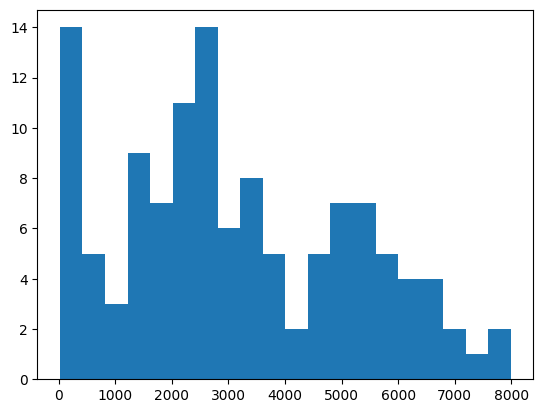

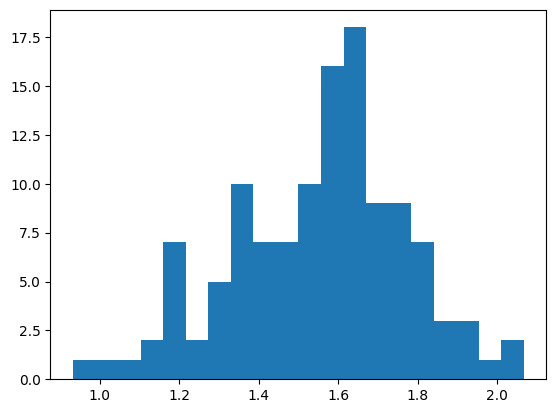

In [57]:
import matplotlib.pyplot as plt

plt.hist(df[c1], bins=20)
plt.show()

plt.hist(df[c2], bins=20)
plt.show()

# Outlier removal

In [ ]:
import stats_outliers
reload(stats_outliers)


X = df_orig[c1].values.reshape(-1, 1)
y = df_orig[c2].values
method = 'influence'
_, _, mask, outlier_scores = stats_outliers.(X, y)
fig = stats_outliers.plot_outlier_detection(X, y, mask, outlier_scores, method=method)

df = df.loc[mask]


Windsorizing: removed 4 points (3.2%) outside of percentile range 0.0050-0.9950


IndexError: Boolean index has wrong length: 125 instead of 121

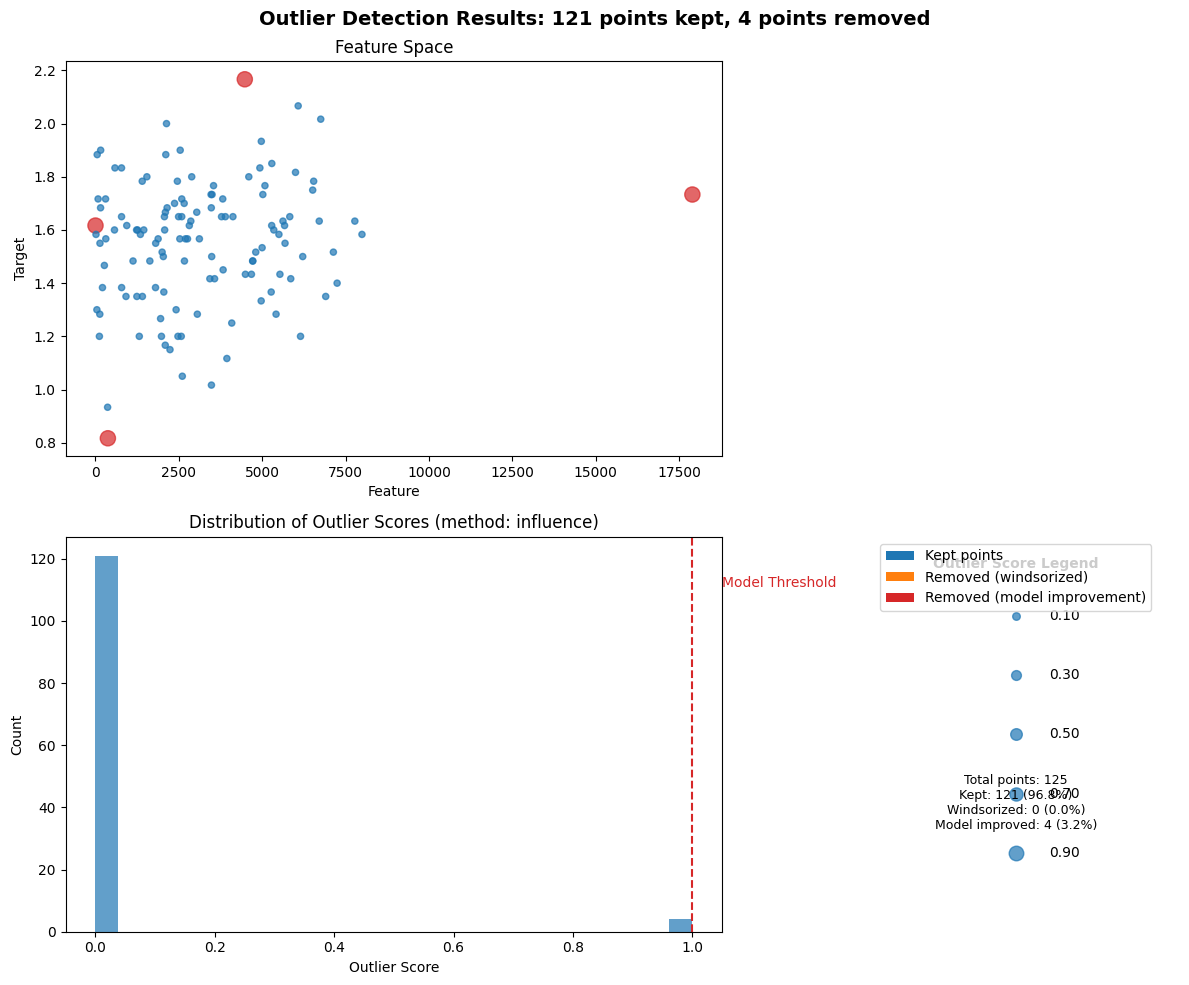

In [58]:
import stats_outliers
reload(stats_outliers)


X = df_orig[c1].values.reshape(-1, 1)
y = df_orig[c2].values
method = 'influence'
_, _, mask, outlier_scores = stats_outliers.windorize_outliers(X, y)
fig = stats_outliers.plot_outlier_detection(X, y, mask, outlier_scores, method=method)

# df = df.loc[mask]


# Simple correlations

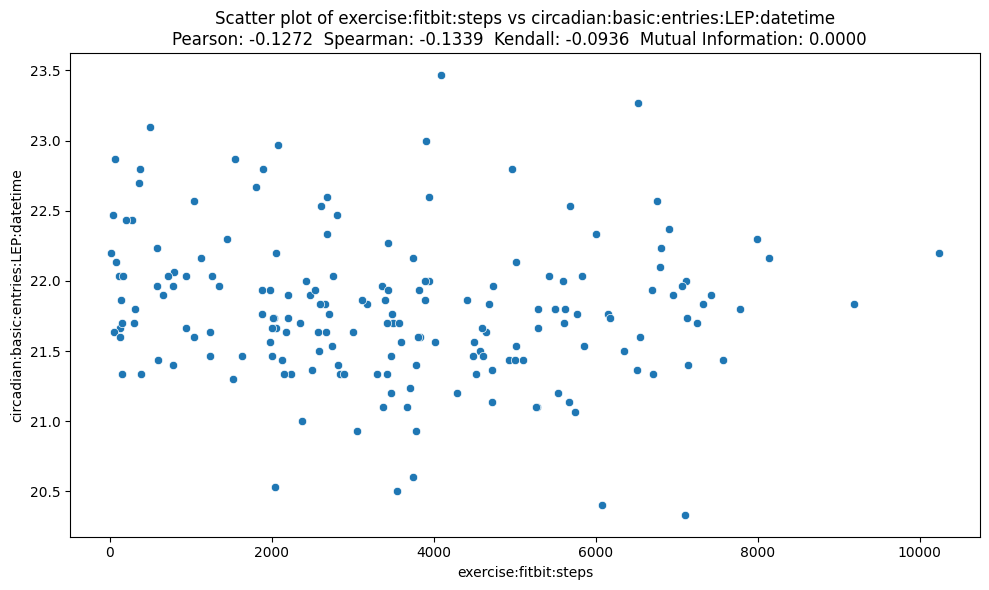

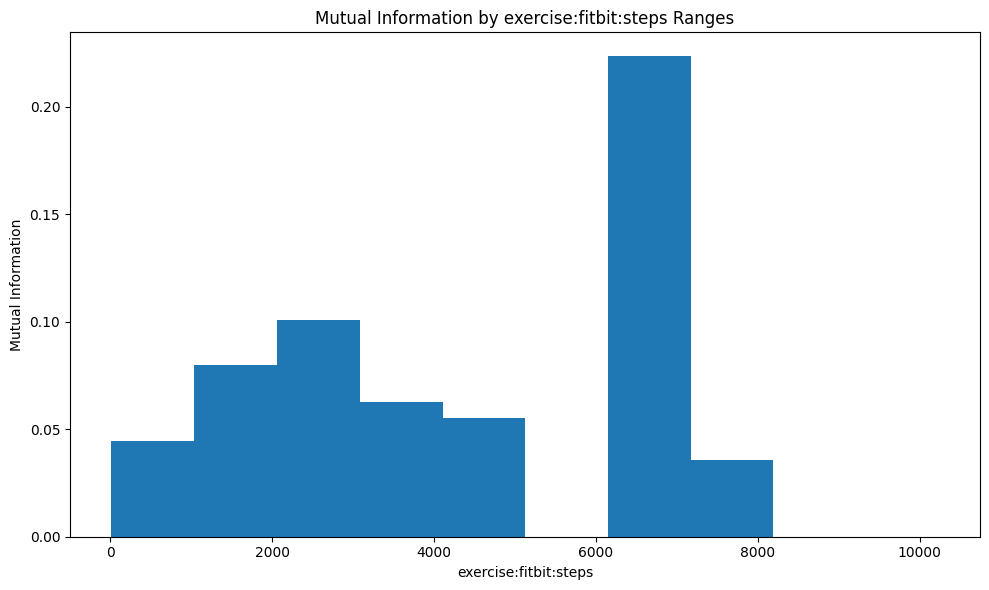

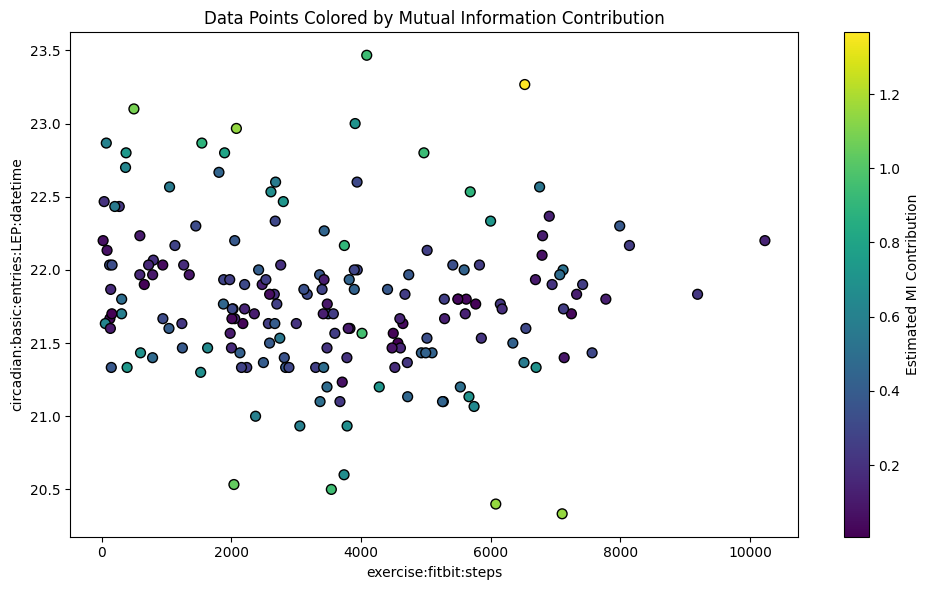

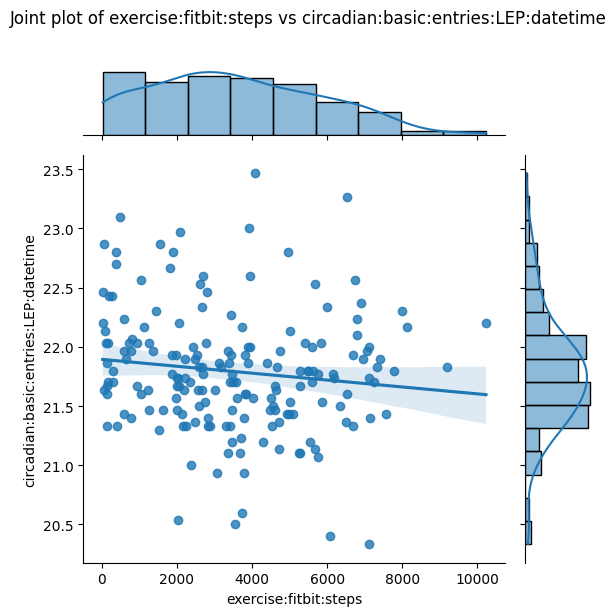

Pearson correlation: -0.1272, p-value: 0.0872
Spearman correlation: -0.1339, p-value: 0.0715
Kendall correlation: -0.0936, p-value: 0.0632
Mutual Information: 0.0000


In [41]:
import stats_two_variables
reload(stats_two_variables)

results = stats_two_variables.calculate_correlations(df, c1, c2)
stats_two_variables.visualize_scatter(df, c1, c2, results)
stats_two_variables.visualize_joint_plot(df, c1, c2)
stats_two_variables.print_correlation_results(results)

# Look for horizontal threshold where linear model works better

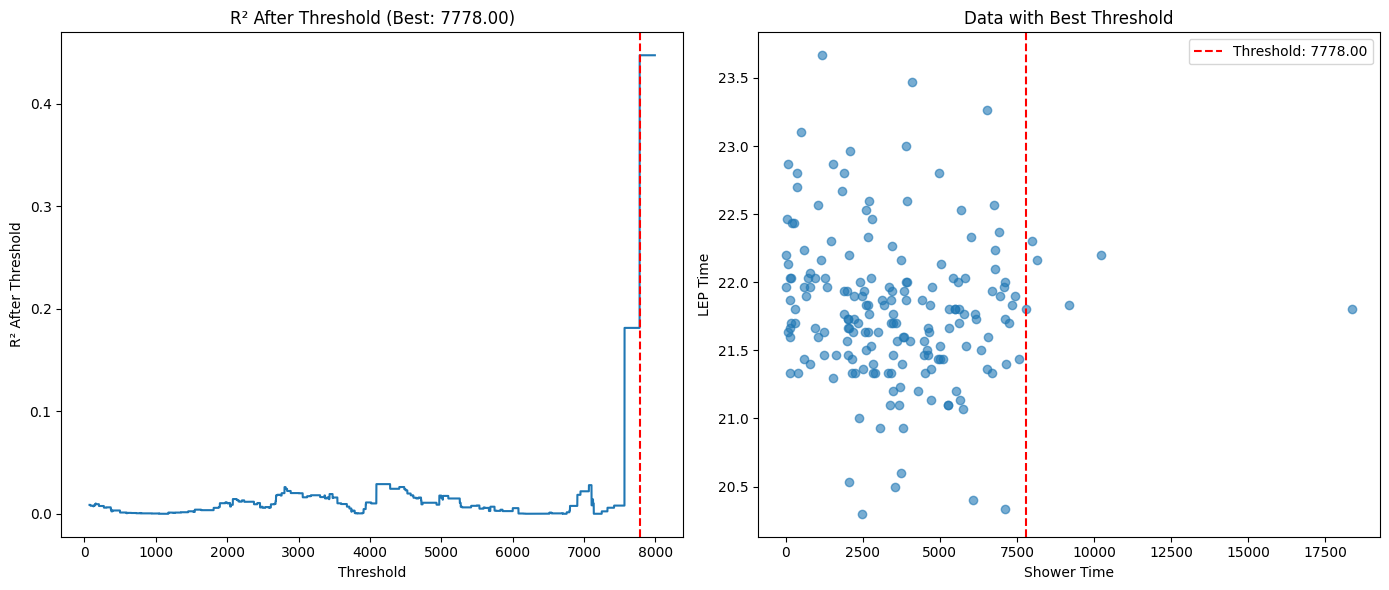

(np.float64(7778.00000000011),
        threshold  points_after  points_before  r2_after  mean_after  std_after
 0           71.0           181              5  0.008695   21.783057   0.535064
 1           71.1           181              5  0.008695   21.783057   0.535064
 2           71.2           181              5  0.008695   21.783057   0.535064
 3           71.3           181              5  0.008695   21.783057   0.535064
 4           71.4           181              5  0.008695   21.783057   0.535064
 ...          ...           ...            ...       ...         ...        ...
 79205     7991.5             5            181  0.447111   22.060000   0.203743
 79206     7991.6             5            181  0.447111   22.060000   0.203743
 79207     7991.7             5            181  0.447111   22.060000   0.203743
 79208     7991.8             5            181  0.447111   22.060000   0.203743
 79209     7991.9             5            181  0.447111   22.060000   0.203743
 
 [79210

In [34]:
import stats_two_variables
reload(stats_two_variables)

X = df[c1].values.reshape(-1, 1)
y = df[c2].values

stats_two_variables.find_optimal_threshold(X, y)

# Clustering

# Machine learning

In [35]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_decision_tree_regressor(df, c1, c2, max_depth=3)

NameError: name 'detect_outliers' is not defined

c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\skl

Outlier removal: removed 1 points (0.8%), R² improved from 0.0000 to 0.0061


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-

Best Gaussian Process Kernel: Complex
Optimized kernel parameters: 0.00316**2 * RBF(length_scale=9.45) + 0.154**2 * DotProduct(sigma_0=0.00108) + WhiteKernel(noise_level=1e-05)
Using 2D GMM clustering on both exercise:fitbit:steps and night:yasa:adjusted:deepSleep
Finding GMM subsets for Gaussian Process (Complex)...

--- Gaussian Process (Complex) Performance within GMM Clusters ---
  GMM - Cluster 0 (Index 0):
    Size: 41 points
    exercise:fitbit:steps range: 3783.00 to 7992.00 (std=1022.13)
    night:yasa:adjusted:deepSleep range: 1.28 to 2.17 (std=0.20)
    CV R² Score: -0.4206 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): -0.0892
    Spearman p-value: 0.5792
    Mutual Information: 0.1738
  GMM - Cluster 1 (Index 1):
    Size: 82 points
    exercise:fitbit:steps range: 5.00 to 4089.00 (std=1144.45)
    night:yasa:adjusted:deepSleep range: 0.82 to 2.00 (std=0.24)
    CV R² Score: -0.0410 (Note: Negative R² indicates mod

c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.

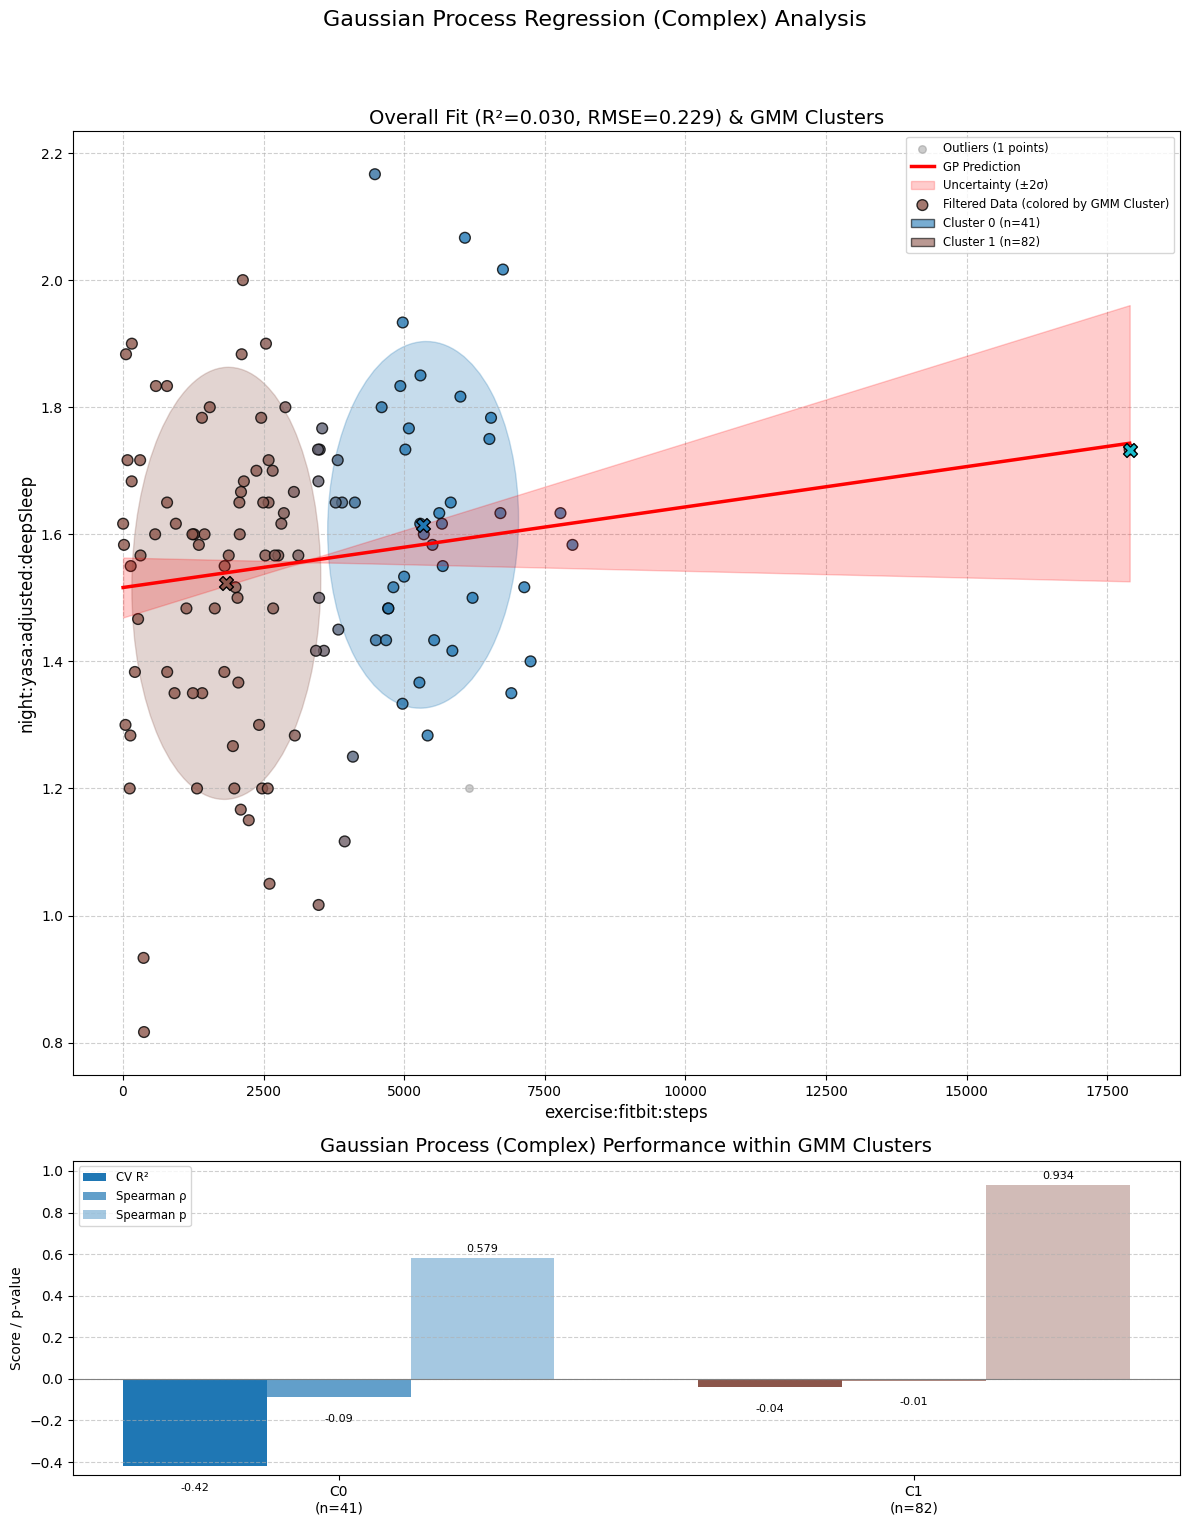


Gaussian Process Regression Results (Kernel: Complex):
R² score: 0.0298
RMSE: 0.2286
Outliers removed: 1 points (0.8%)
Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [ ]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_gaussian_process_regressor(df, c1, c2, alpha=1.0)

Outlier removal: removed 12 points (9.6%), R² improved from 0.0214 to 0.0980
Using 2D GMM clustering on both exercise:fitbit:steps and night:yasa:adjusted:deepSleep
Finding GMM subsets for SVR (rbf, C=1.0)...

--- SVR (rbf, C=1.0) Performance within GMM Clusters ---
  GMM - Cluster 0 (Index 0):
    Size: 36 points
    exercise:fitbit:steps range: 3783.00 to 7992.00 (std=1062.95)
    night:yasa:adjusted:deepSleep range: 1.33 to 2.17 (std=0.19)
    CV R² Score: -0.4399 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): -0.0108
    Spearman p-value: 0.9500
    Mutual Information: 0.3026
  GMM - Cluster 1 (Index 1):
    Size: 76 points
    exercise:fitbit:steps range: 5.00 to 4089.00 (std=1115.95)
    night:yasa:adjusted:deepSleep range: 0.82 to 2.00 (std=0.23)
    CV R² Score: -0.1077 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): 0.0357
    Spearman p-value: 0.7592
    Mutual

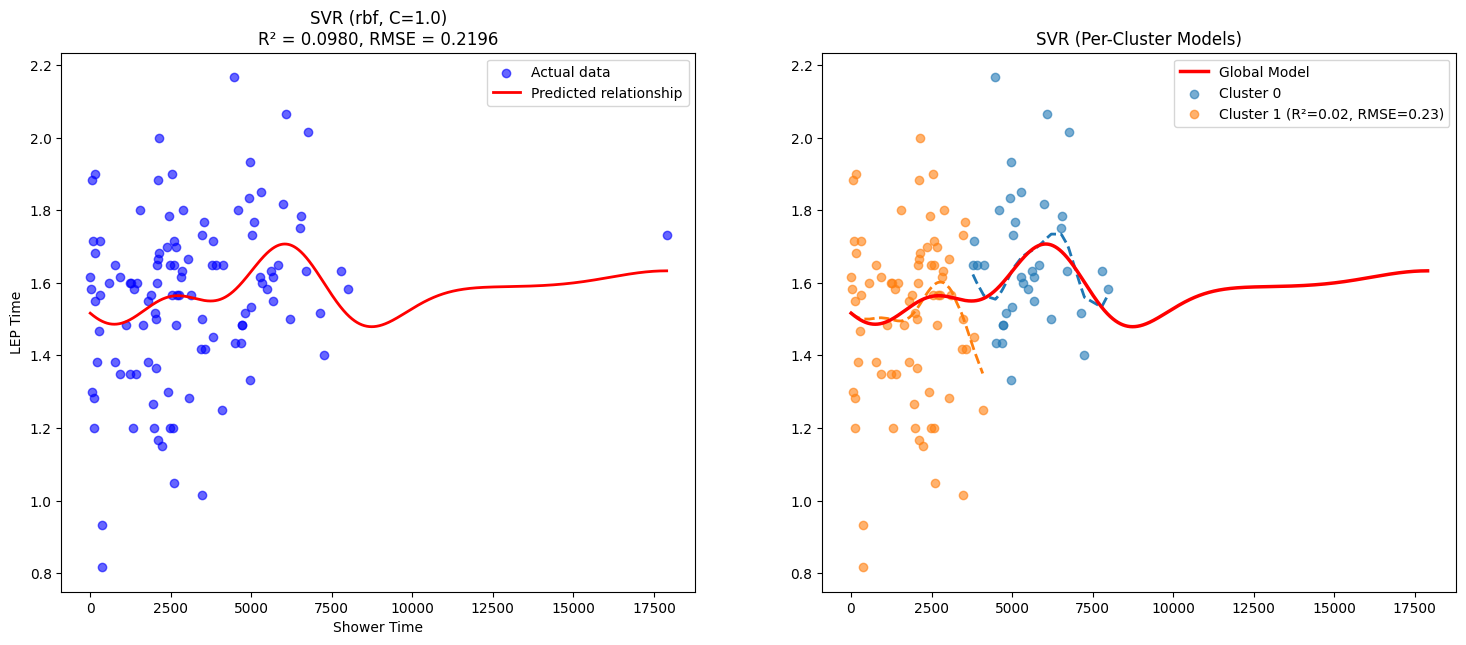

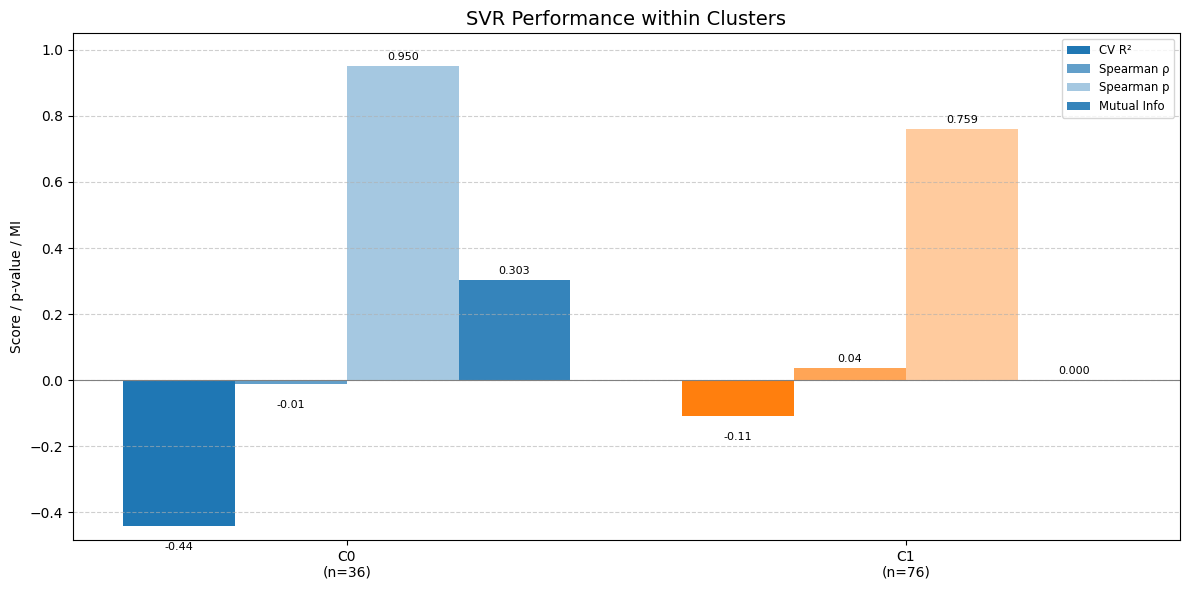

<Figure size 640x480 with 0 Axes>

SVR (rbf, C=1.0) Performance:
R²: 0.0980
MAE: 0.1726
RMSE: 0.2196

Per-Cluster Model Performance:
  Cluster 0 (size: 36): R²=-0.4399, RMSE=0.1851, MI=0.3026
  Cluster 1 (size: 76): R²=-0.1077, RMSE=0.2344, MI=0.0000
Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [ ]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_svr(df, c1, c2)

Using 2D GMM clustering on both exercise:fitbit:steps and night:yasa:adjusted:deepSleep
Finding GMM subsets for k-NN Regressor (k=3)...

--- k-NN Regressor (k=3) Performance within GMM Clusters ---
  GMM - Cluster 0 (Index 0):
    Size: 81 points
    exercise:fitbit:steps range: 5.00 to 3943.00 (std=1123.97)
    night:yasa:adjusted:deepSleep range: 0.82 to 2.00 (std=0.24)
    CV R² Score: -0.3938 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): 0.0176
    Spearman p-value: 0.8762
    Mutual Information: 0.0000
  GMM - Cluster 1 (Index 1):
    Size: 43 points
    exercise:fitbit:steps range: 3783.00 to 7992.00 (std=1025.98)
    night:yasa:adjusted:deepSleep range: 1.20 to 2.17 (std=0.21)
    CV R² Score: -0.5878 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): -0.0611
    Spearman p-value: 0.6969
    Mutual Information: 0.1727
Skipping GMM cluster 2 due to insufficient data 

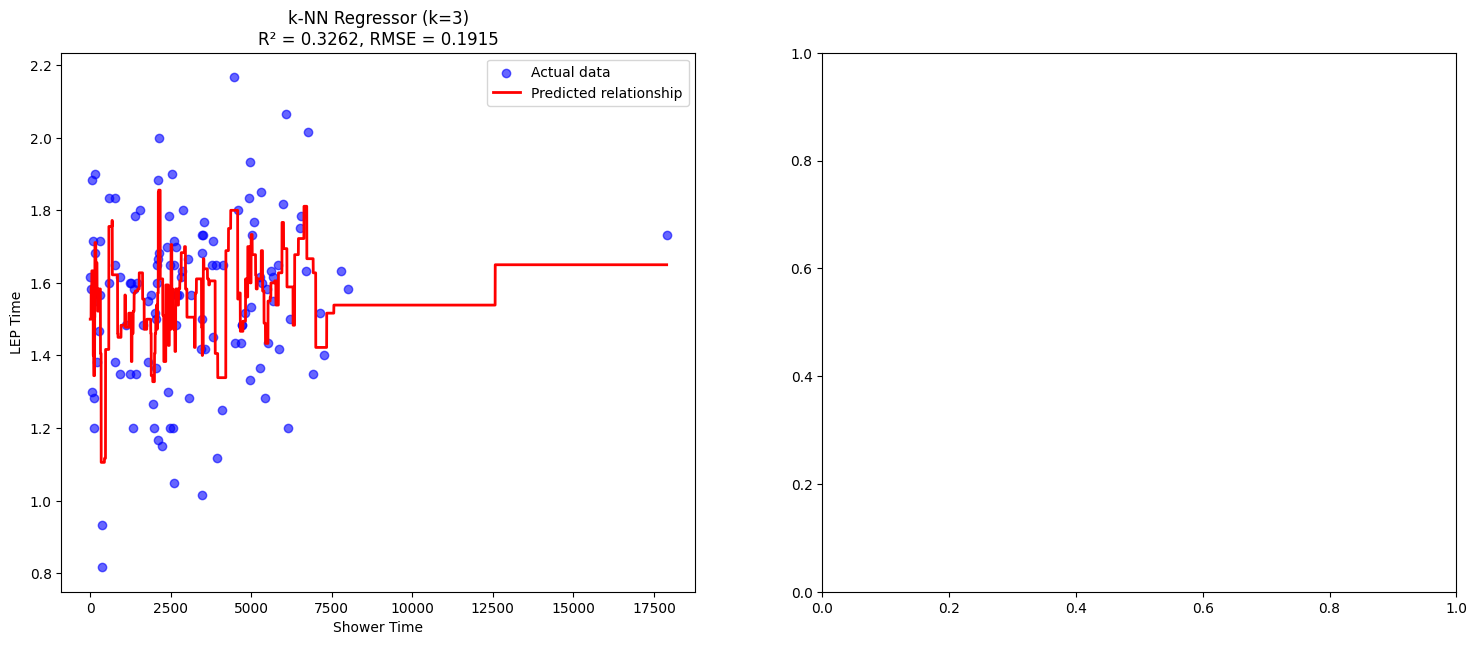

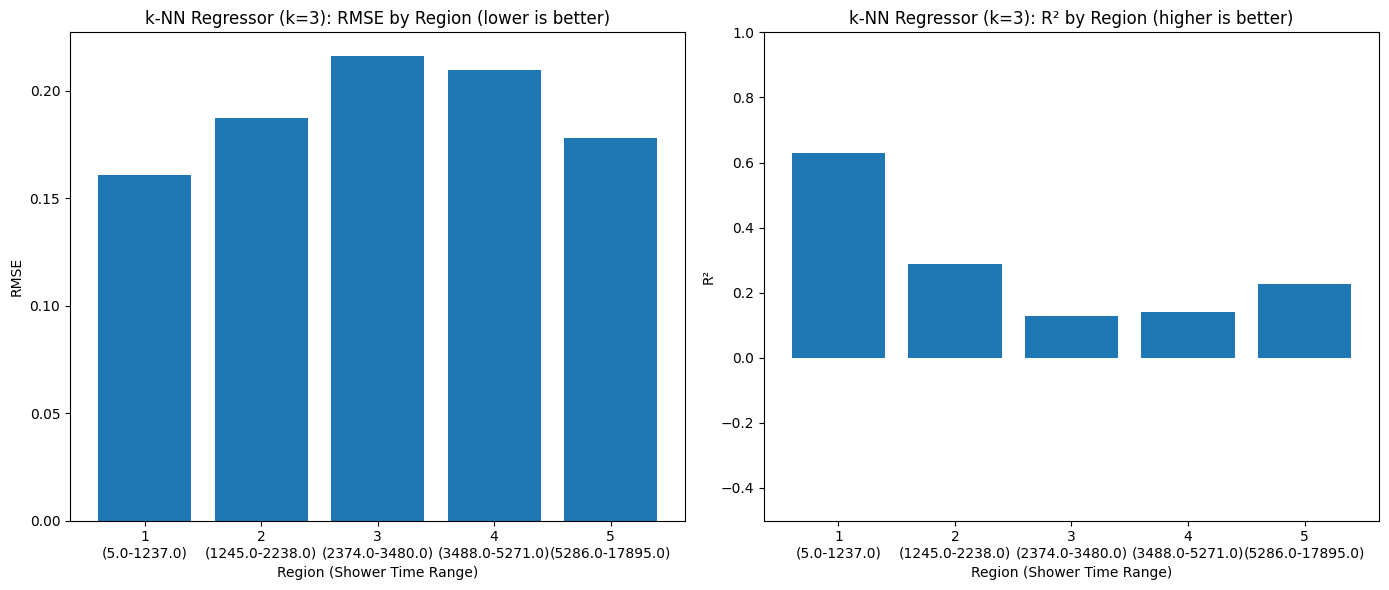

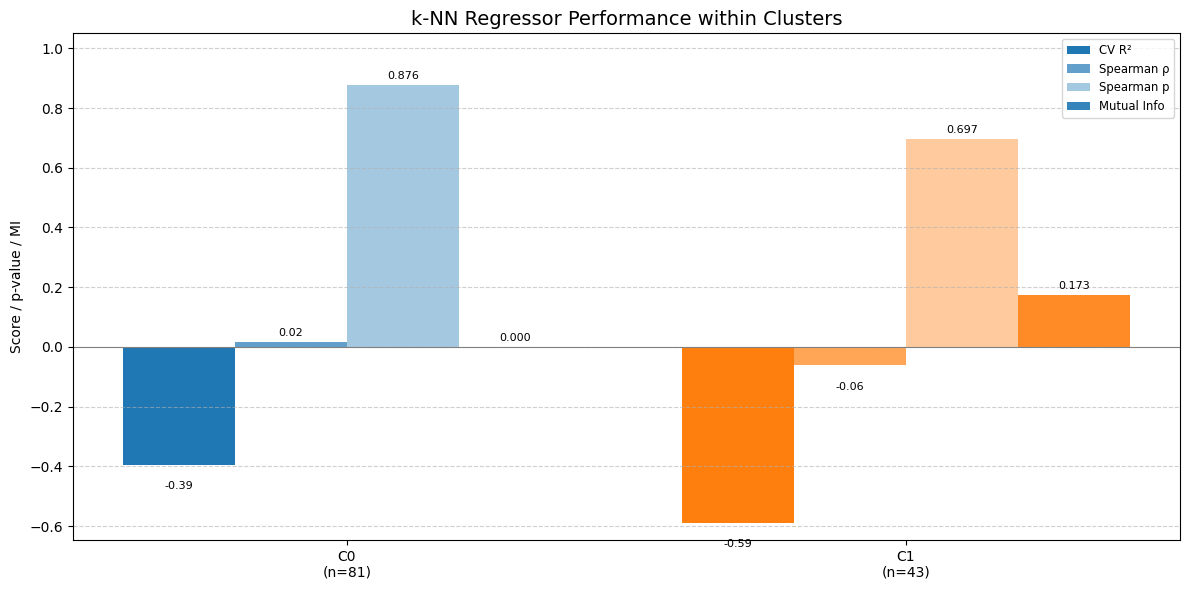

<Figure size 640x480 with 0 Axes>

k-NN Regression Results (k=3):
R² score: 0.3262
RMSE: 0.1915

Per-Cluster Model Performance:
  Cluster 0 (size: 81): R²=-0.3938, RMSE=0.2387, MI=0.0000
  Cluster 1 (size: 43): R²=-0.5878, RMSE=0.2124, MI=0.1727
Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [ ]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_knn_regressor(df, c1, c2)




Random Forest Feature Importance: 1.0000
Using 2D GMM clustering on both exercise:fitbit:steps and night:yasa:adjusted:deepSleep
Finding GMM subsets for Random Forest (n=50, depth=5)...

--- Random Forest (n=50, depth=5) Performance within GMM Clusters ---
  GMM - Cluster 0 (Index 0):
    Size: 81 points
    exercise:fitbit:steps range: 5.00 to 3943.00 (std=1123.97)
    night:yasa:adjusted:deepSleep range: 0.82 to 2.00 (std=0.24)
    CV R² Score: -0.3453 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): 0.0176
    Spearman p-value: 0.8762
    Mutual Information: 0.0000
  GMM - Cluster 1 (Index 1):
    Size: 43 points
    exercise:fitbit:steps range: 3783.00 to 7992.00 (std=1025.98)
    night:yasa:adjusted:deepSleep range: 1.20 to 2.17 (std=0.21)
    CV R² Score: -0.7177 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): -0.0611
    Spearman p-value: 0.6969
    Mutual Informati

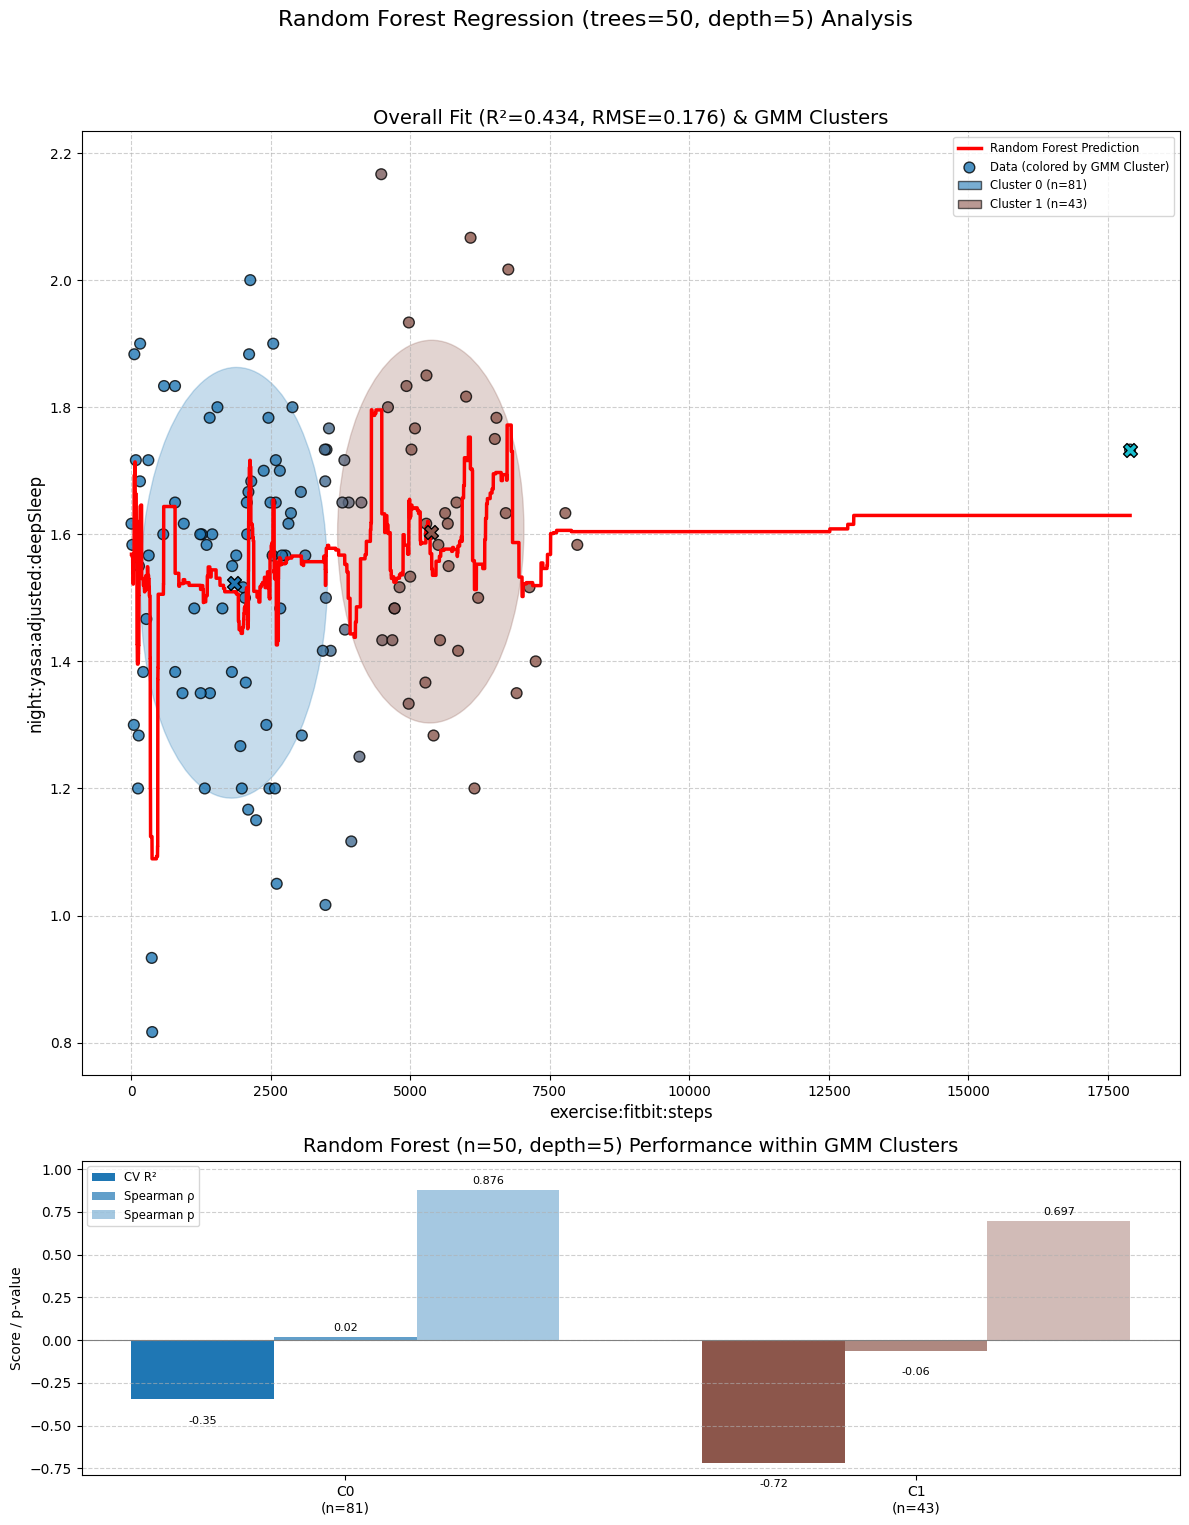

Random Forest Regression Results (trees=50, depth=5):
R² score: 0.4336
RMSE: 0.1756
Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [ ]:
import stats_two_variables
reload(stats_two_variables)


models = stats_two_variables.fit_random_forest_regressor(df, c1, c2)


# Linear 

Outlier removal: removed 12 points (9.6%), R² improved from 0.0259 to 0.1057
Using 2D GMM clustering on both exercise:fitbit:steps and night:yasa:adjusted:deepSleep
Finding GMM subsets for Linear Regression...

--- Linear Regression Performance within GMM Clusters ---
  GMM - Cluster 0 (Index 0):
    Size: 45 points
    exercise:fitbit:steps range: 3476.00 to 7992.00 (std=1126.48)
    night:yasa:adjusted:deepSleep range: 1.25 to 2.17 (std=0.19)
    CV R² Score: -0.1750 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): 0.1033
    Spearman p-value: 0.4997
    Mutual Information: 0.1270
  GMM - Cluster 1 (Index 1):
    Size: 67 points
    exercise:fitbit:steps range: 5.00 to 3480.00 (std=987.38)
    night:yasa:adjusted:deepSleep range: 0.82 to 1.90 (std=0.23)
    CV R² Score: 0.0133
    Spearman Correlation (ρ): 0.1963
    Spearman p-value: 0.1114
    Mutual Information: 0.0000
Skipping GMM cluster 2 due to insufficient data points (

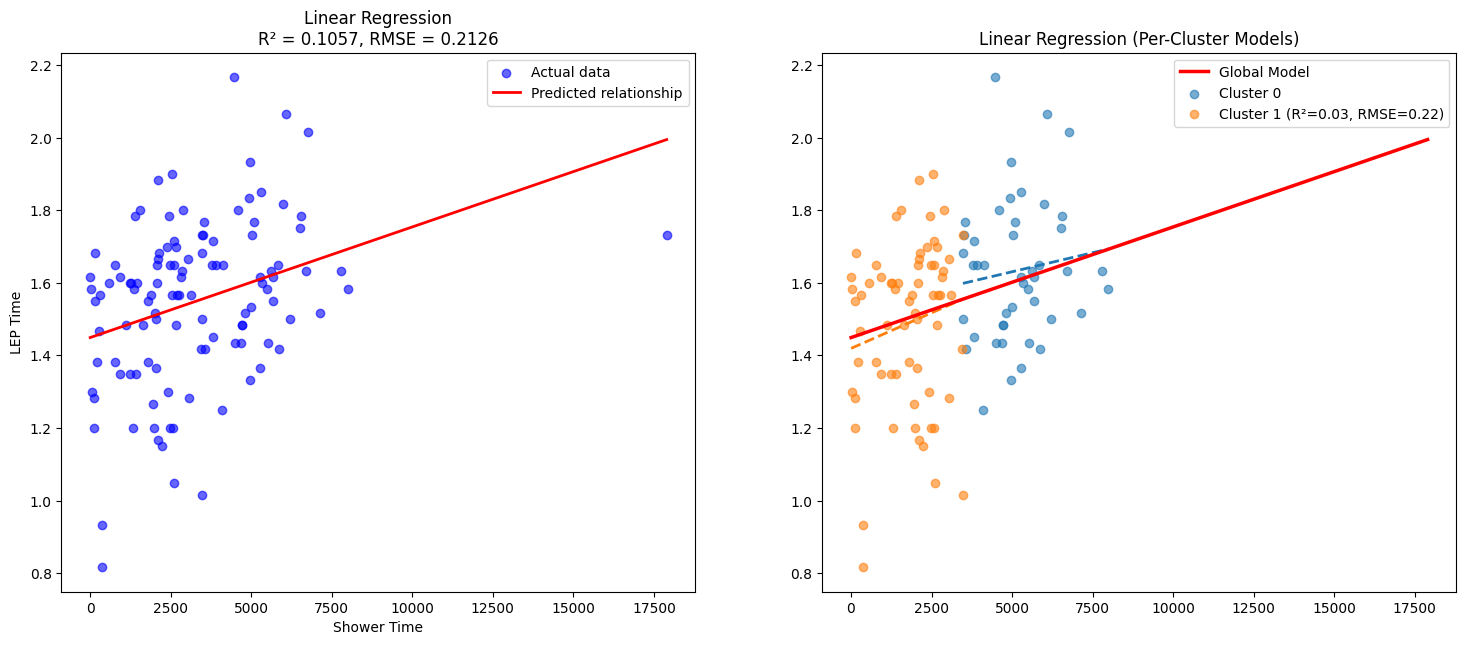

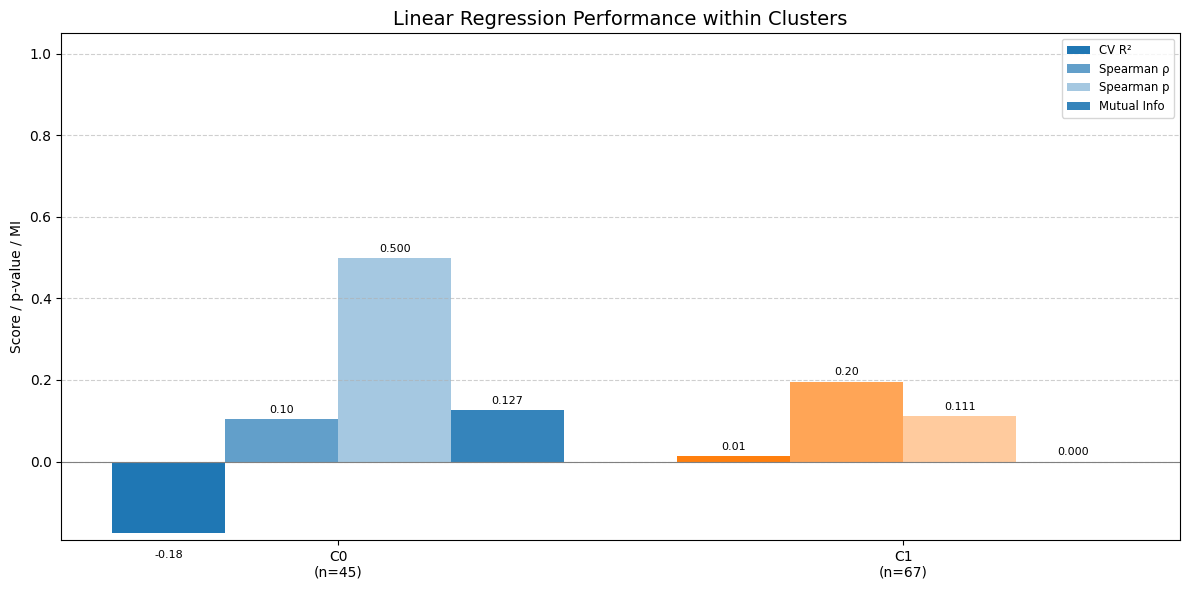

<Figure size 640x480 with 0 Axes>

Linear Regression Performance:
R²: 0.1057
MAE: 0.1696
RMSE: 0.2126

Per-Cluster Model Performance:
  Cluster 0 (size: 45): R²=-0.1750, RMSE=0.1913, MI=0.1270
  Cluster 1 (size: 67): R²=0.0133, RMSE=0.2257, MI=0.0000
Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [350]:
import stats_two_variables

reload(stats_two_variables)

models = stats_two_variables.fit_linear_regression(df, c1, c2)




# Symbolic representation

In [ ]:
from pysr import PySRRegressor

df2 = df.copy().drop(columns=['Diff'])
X = df2.drop(columns=[c2])
y = df2[c2]
X.columns = X.columns.str.replace(':', '_')
y.name = y.name.replace(':', '_')

model = PySRRegressor(niterations=30, progress=True)
model.fit(X, y)


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\pysr\sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	   pick     score  \
	0        0.000000   
	1        0.006568   
	2  >>>>  0.054943   
	3        0.000187   
	4        0.025126   
	5        0.000089   
	6        0.000025   
	7        0.000750   
	8        0.000060   
	9        0.000021   
	
	                                                                                                                                                                                                                                                             equation  \
	0                                                                                                                                                                                                                                                           1.5538574   
	1                                                                                                                                                                                                                  1.504361 - (exercise_fitbit_steps * -1.5389665e-5)   
	2                                                                                                                                                                                                       (8.0252285 / (exercise_fitbit_steps + -386.0486)) + 1.5646086   
	3                                                                                                                                     (((exercise_fitbit_steps + (-6820.9 / exercise_fitbit_steps)) * 0.024617193) / (exercise_fitbit_steps + -387.6146)) + 1.5386722   
	4                                                                                                                       ((7.8048506 - (19.11095 / ((exercise_fitbit_steps + -6802.6436) / exercise_fitbit_steps))) / (exercise_fitbit_steps + -387.71405)) + 1.555514   
	5                                                                                                         (((-20.216991 / ((exercise_fitbit_steps + -6804.17) / (exercise_fitbit_steps + 1.3235595))) - -7.378252) / (exercise_fitbit_steps + -387.1749)) + 1.5513065   
	6                                                                          ((exercise_fitbit_steps * (((-0.0029822662 / ((exercise_fitbit_steps + -6806.084) / exercise_fitbit_steps)) - 0.08659377) + 0.10924721)) / (exercise_fitbit_steps + -387.4603)) + 1.534263   
	7                                                   ((((exercise_fitbit_steps + (-6800.9307 / exercise_fitbit_steps)) * 0.0209848) + (-19.993158 / ((exercise_fitbit_steps + -6801.1113) / exercise_fitbit_steps))) / (exercise_fitbit_steps + -387.6225)) + 1.531925   
	8                                 (((((exercise_fitbit_steps * 0.82218844) + (-6800.9307 / exercise_fitbit_steps)) * 0.025859706) + (-19.997444 / ((exercise_fitbit_steps + -6800.9307) / exercise_fitbit_steps))) / (exercise_fitbit_steps + -387.6195)) + 1.5307611   
	9  (((((exercise_fitbit_steps + (-6800.9307 / exercise_fitbit_steps)) * 0.021389404) + (-20.003023 / (((exercise_fitbit_steps - 1.5891005) + -6800.947) / exercise_fitbit_steps))) - 0.16737066) / ((exercise_fitbit_steps - -0.058150154) + -387.61572)) + 1.5312372   
	
	       loss  complexity  
	0  0.054432           1  
	1  0.053020           5  
	2  0.047503           7  
	3  0.047450          13  
	4  0.045124          15  
	5  0.045116          17  
	6  0.045114          19  
	7  0.045046          21  
	8  0.045041          23  
	9  0.045037          27  
]

Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [352]:
import pandas as pd

equation_df = model.equations_
print(equation_df[['equation', 'loss', 'complexity']])


                                                                                                                                                                                                                                                             equation  \
0                                                                                                                                                                                                                                                           1.5538574   
1                                                                                                                                                                                                                  1.504361 - (exercise_fitbit_steps * -1.5389665e-5)   
2                                                                                                                                                                                                       (8.02

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

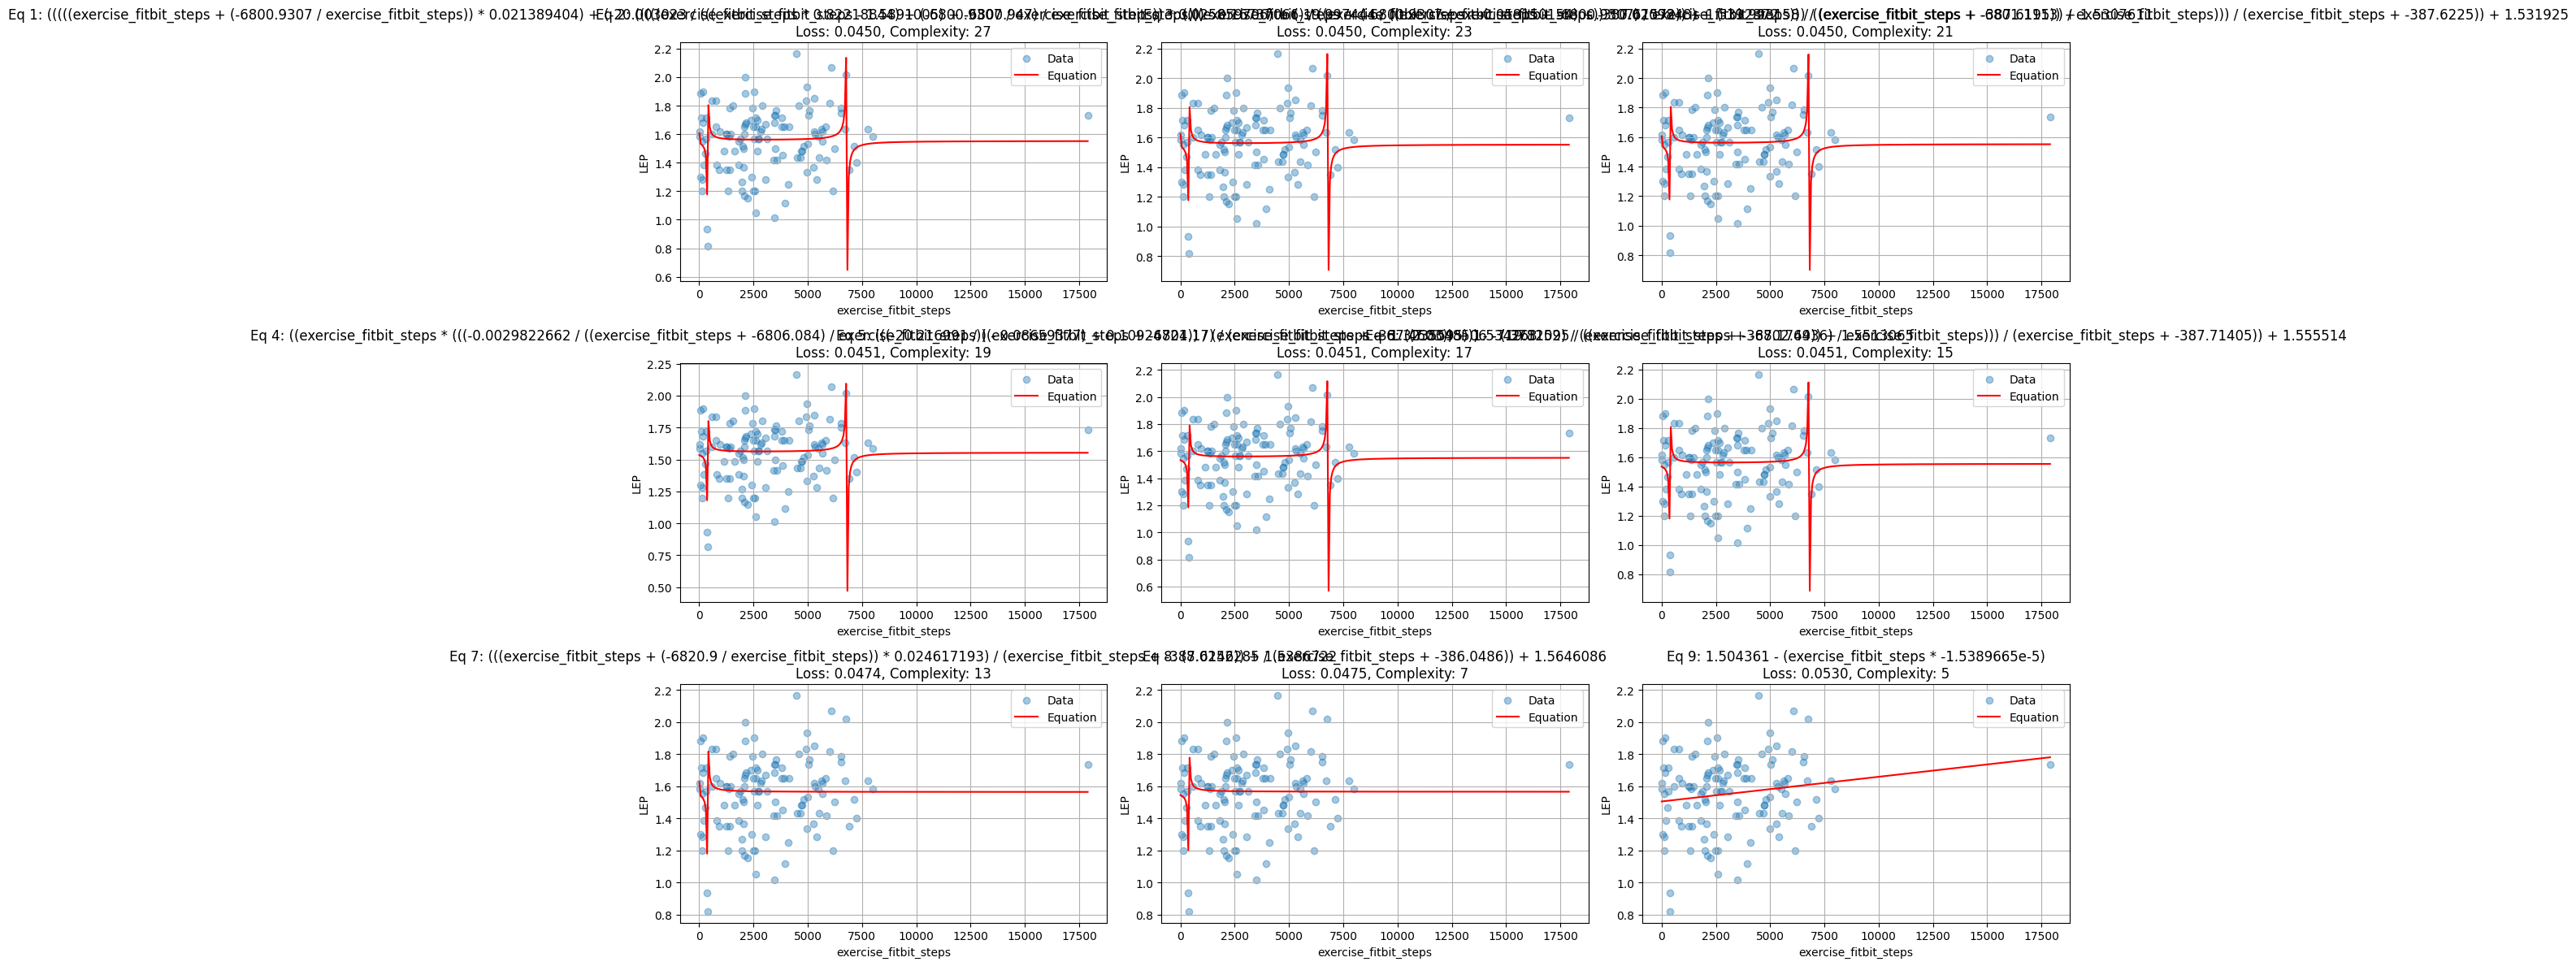

Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sp
from sympy.utilities.lambdify import lambdify

# Define your feature
feature = X.columns[0]
x_vals = np.linspace(X[feature].min(), X[feature].max(), 300)
x_df = pd.DataFrame({feature: x_vals})

# Define output y range to clip
Y_CLIP_MIN, Y_CLIP_MAX = y.min() - 1, y.max() + 1

# Top 9 equations
top_equations = model.equations_.sort_values("loss").head(9)

x_sym = sp.Symbol(feature)

plt.figure(figsize=(18, 12))
for i, row in enumerate(top_equations.itertuples(), 1):
    try:
        expr = sp.sympify(row.equation)
        func = lambdify(x_sym, expr, modules=["numpy"])
        y_vals = func(x_vals)

        # Handle crazy outputs
        y_vals = np.nan_to_num(y_vals, nan=np.nan, posinf=np.nan, neginf=np.nan)
        y_vals = np.clip(y_vals, Y_CLIP_MIN, Y_CLIP_MAX)

        plt.subplot(3, 3, i)
        plt.scatter(X[feature], y, alpha=0.4, label="Data")
        plt.plot(x_vals, y_vals, color='red', label="Equation")
        plt.title(f"Eq {i}: {row.equation}\nLoss: {row.loss:.4f}, Complexity: {row.complexity}")
        plt.xlabel(feature)
        plt.ylabel("LEP")
        plt.legend()
        plt.grid(True)

    except Exception as e:
        print(f"⚠️ Skipped equation {i} due to error:\n{row.equation}\n{e}")

plt.tight_layout()
plt.show()


# Neural nets

Epoch [100/500], Loss: 0.971741
Epoch [200/500], Loss: 0.971668
Epoch [300/500], Loss: 0.971605
Epoch [400/500], Loss: 0.971563
Epoch [500/500], Loss: 0.971548
Epoch [100/500], Loss: 0.974087
Epoch [200/500], Loss: 0.973992
Epoch [300/500], Loss: 0.973932
Epoch [400/500], Loss: 0.973696
Epoch [500/500], Loss: 0.973605
Epoch [100/500], Loss: 0.974638
Epoch [200/500], Loss: 0.974075
Epoch [300/500], Loss: 0.973208
Epoch [400/500], Loss: 0.972153
Epoch [500/500], Loss: 0.970942
Epoch [100/500], Loss: 0.978275
Epoch [200/500], Loss: 0.977658
Epoch [300/500], Loss: 0.977272
Epoch [400/500], Loss: 0.977078
Epoch [500/500], Loss: 0.976624
Epoch [100/500], Loss: 0.973279
Epoch [200/500], Loss: 0.973167
Epoch [300/500], Loss: 0.973132
Epoch [400/500], Loss: 0.973107
Epoch [500/500], Loss: 0.973080
Epoch [100/500], Loss: 0.971708
Epoch [200/500], Loss: 0.970108
Epoch [300/500], Loss: 0.967970
Epoch [400/500], Loss: 0.966766
Epoch [500/500], Loss: 0.966219
Epoch [100/500], Loss: 0.970102
Epoch [2

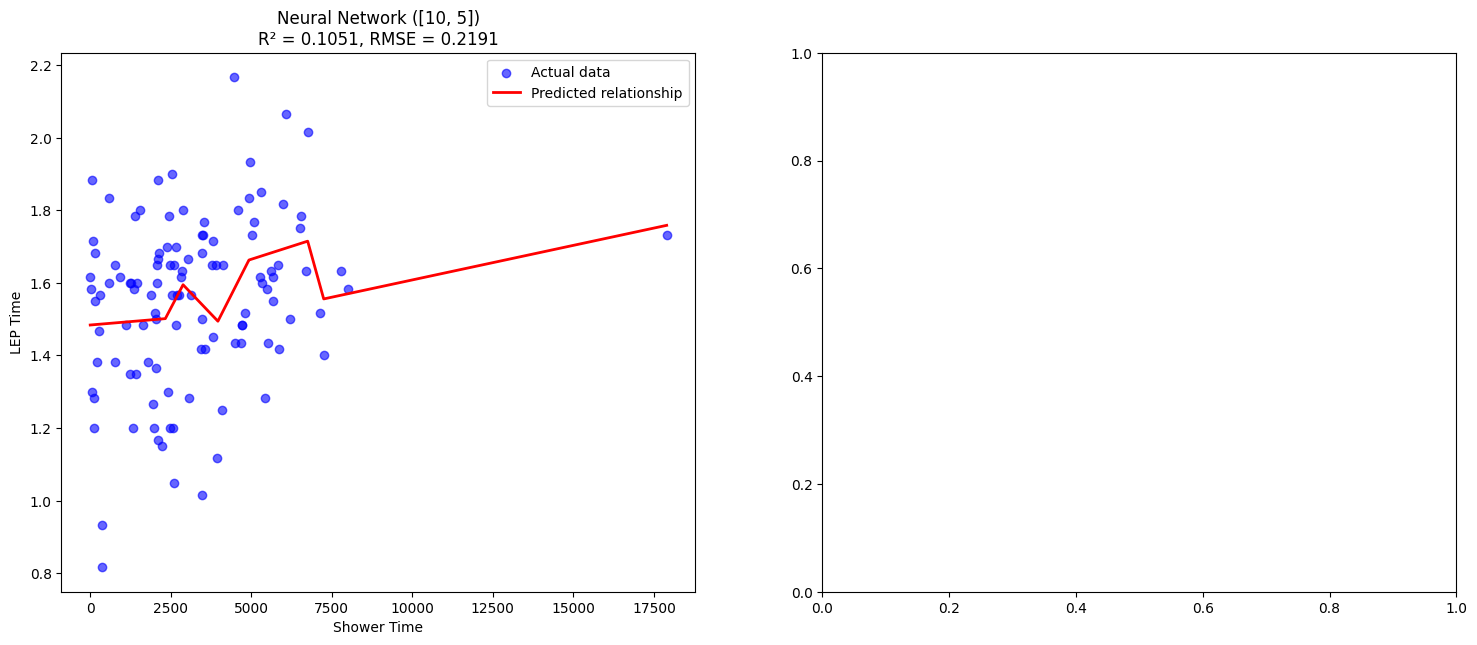

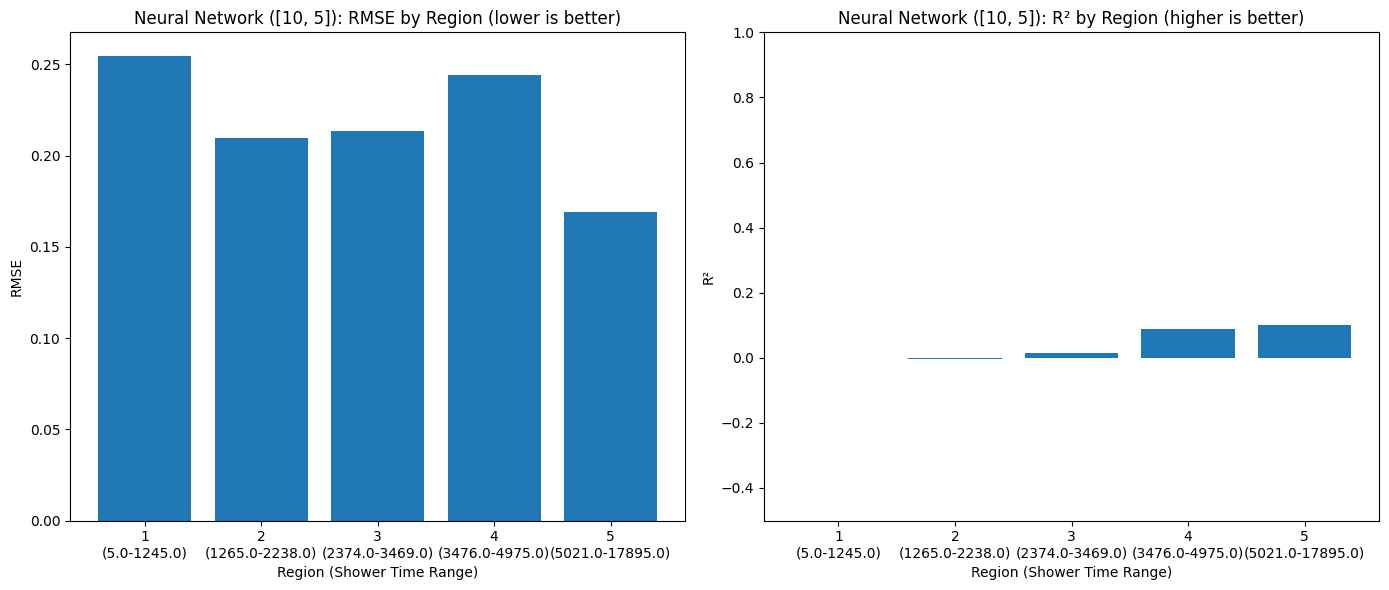

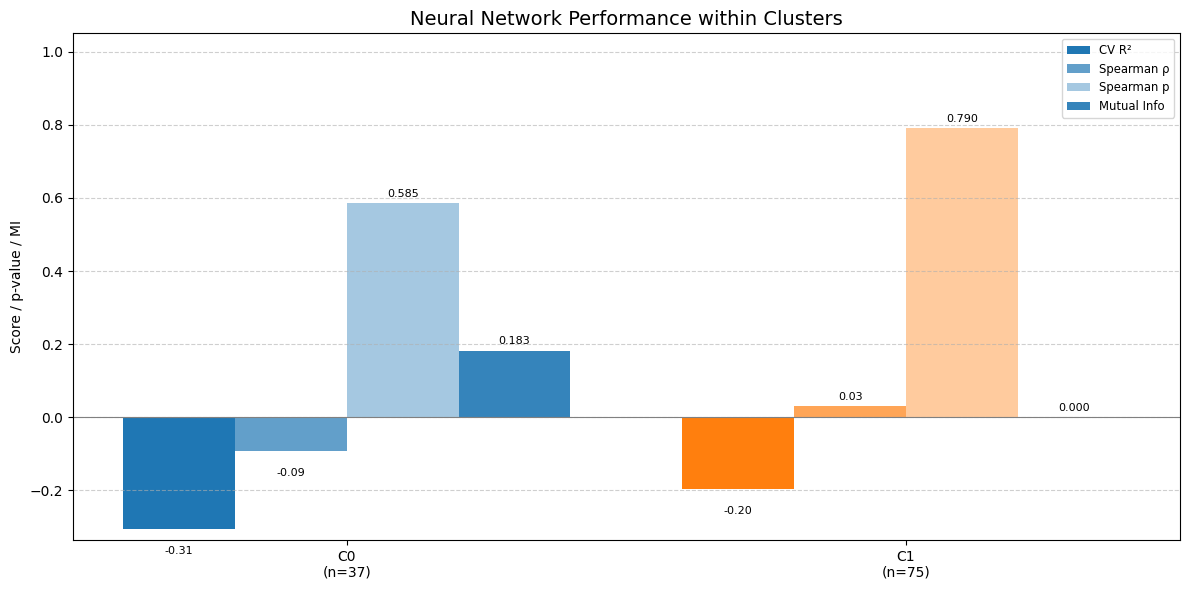

<Figure size 640x480 with 0 Axes>

Neural Network ([10, 5]) Results:
R² score: 0.1051
RMSE: 0.2191

Per-Cluster Model Performance:
  Cluster 0 (size: 37): R²=-0.3053, RMSE=0.1918, MI=0.1825
  Cluster 1 (size: 75): R²=-0.1971, RMSE=0.2332, MI=0.0000
Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [ ]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_pytorch_neural_net(df, c1, c2)

In [358]:
import stats_two_variables
reload(stats_two_variables)
from sklearn.linear_model import LinearRegression


X = df[[c1]].values
y = df[c2].values

stats_two_variables.detect_outliers(X, y, model_factory=lambda X, y: LinearRegression().fit(X, y))

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True]),
 array([0.1

Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

# Rules

Outlier removal: removed 12 points (9.6%), R² improved from 0.0259 to 0.1057
RuleFit Rules:
                                                                                                                                          rule  \
207                                                 exercise:fitbit:steps > -0.48449942469596863 & exercise:fitbit:steps > -1.3276944756507874   
10                                                   exercise:fitbit:steps > -0.2756824344396591 & exercise:fitbit:steps > 0.35348042845726013   
315                                                   exercise:fitbit:steps > 0.0960576981306076 & exercise:fitbit:steps > 0.09125970304012299   
309  exercise:fitbit:steps <= 0.08979944512248039 & exercise:fitbit:steps <= -1.1633110642433167 & exercise:fitbit:steps > -1.3458434343338013   
907   exercise:fitbit:steps <= 0.6720254123210907 & exercise:fitbit:steps > -1.3458434343338013 & exercise:fitbit:steps <= -0.7819749712944031   
31                              

c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.427e-04, tolerance: 4.519e-05
  model = cd_fast.enet_coordinate_descent(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.405e-04, tolerance: 8.333e-05
  model = cd_fast.enet_coordinate_descent(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

  GMM - Cluster 0 (Index 0):
    Size: 45 points
    exercise:fitbit:steps range: 3476.00 to 7992.00 (std=1126.48)
    night:yasa:adjusted:deepSleep range: 1.25 to 2.17 (std=0.19)
    CV R² Score: -0.1615 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): 0.1033
    Spearman p-value: 0.4997
    Mutual Information: 0.1270


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.379e-04, tolerance: 1.087e-04
  model = cd_fast.enet_coordinate_descent(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.606e-04, tolerance: 1.087e-04
  model = cd_fast.enet_coordinate_descent(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

  GMM - Cluster 1 (Index 1):
    Size: 67 points
    exercise:fitbit:steps range: 5.00 to 3480.00 (std=987.38)
    night:yasa:adjusted:deepSleep range: 0.82 to 1.90 (std=0.23)
    CV R² Score: -0.0101 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): 0.1963
    Spearman p-value: 0.1114
    Mutual Information: 0.0000
Skipping GMM cluster 2 due to insufficient data points (1 < 5)


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.131e-03, tolerance: 1.381e-04
  model = cd_fast.enet_coordinate_descent(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.853e-03, tolerance: 1.381e-04
  model = cd_fast.enet_coordinate_descent(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

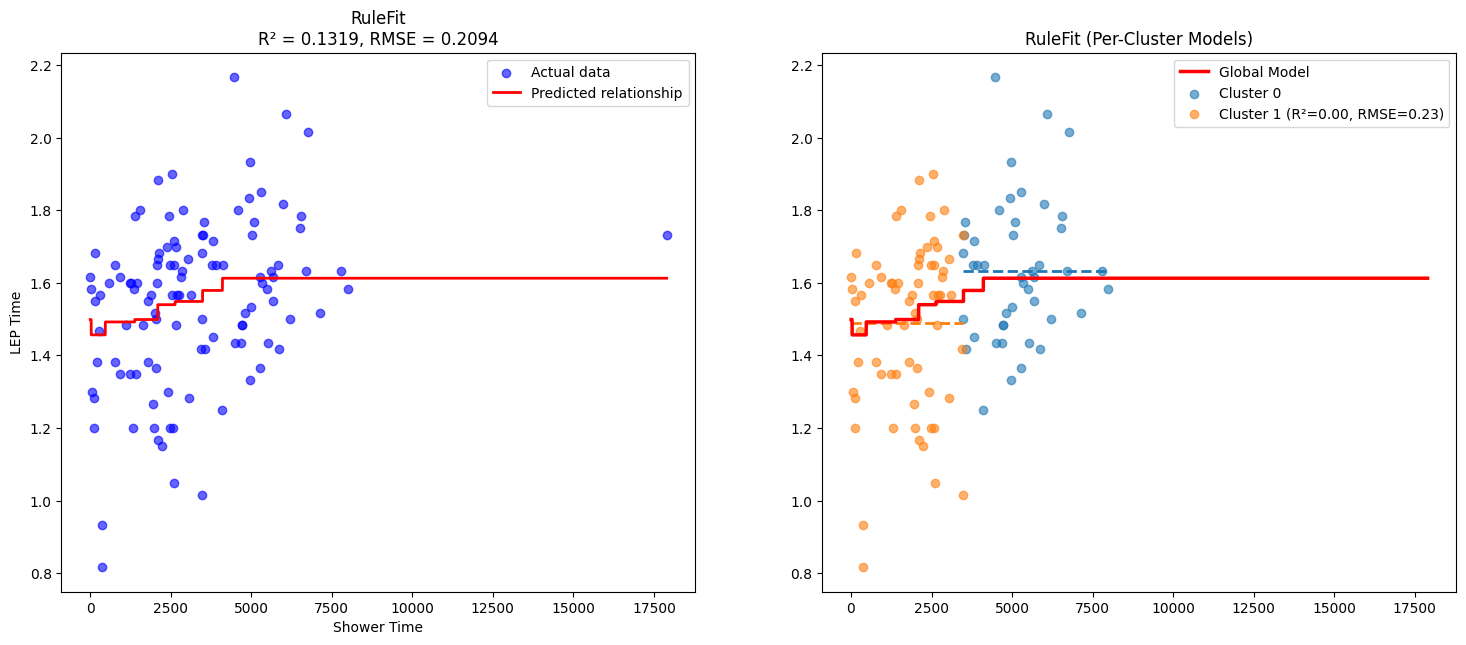

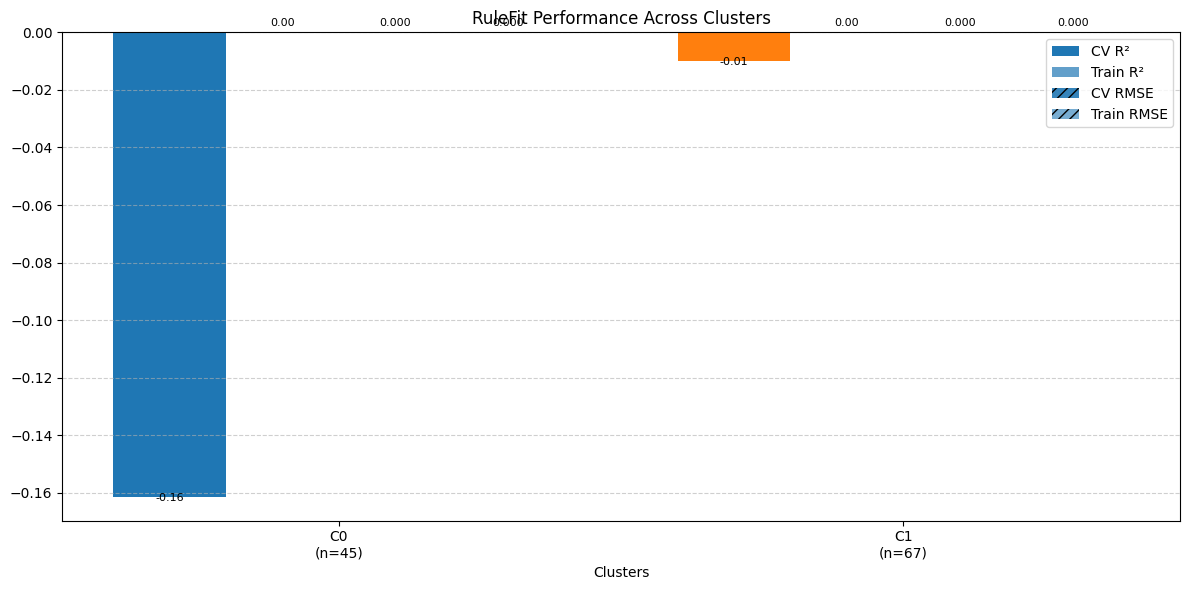

<Figure size 640x480 with 0 Axes>

Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [376]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_rulefit(df, c1, c2)

Outlier removal: removed 12 points (9.6%), R² improved from 0.0259 to 0.1057
RIPPER Rules:
[[exercise:fitbit:steps=0.51-0.75] V [exercise:fitbit:steps=>1.08] V [exercise:fitbit:steps=0.093-0.51]]
Using 2D GMM clustering on both exercise:fitbit:steps and night:yasa:adjusted:deepSleep
Finding GMM subsets for RIPPER...

--- RIPPER Performance within GMM Clusters ---
  GMM - Cluster 0 (Index 0):
    Size: 45 points
    exercise:fitbit:steps range: 3476.00 to 7992.00 (std=1126.48)
    night:yasa:adjusted:deepSleep range: 1.25 to 2.17 (std=0.19)
    CV R² Score: -2.1004 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): 0.1033
    Spearman p-value: 0.4997
    Mutual Information: 0.1270
  GMM - Cluster 1 (Index 1):
    Size: 67 points
    exercise:fitbit:steps range: 5.00 to 3480.00 (std=987.38)
    night:yasa:adjusted:deepSleep range: 0.82 to 1.90 (std=0.23)
    CV R² Score: -2.5861 (Note: Negative R² indicates model performs worse than 

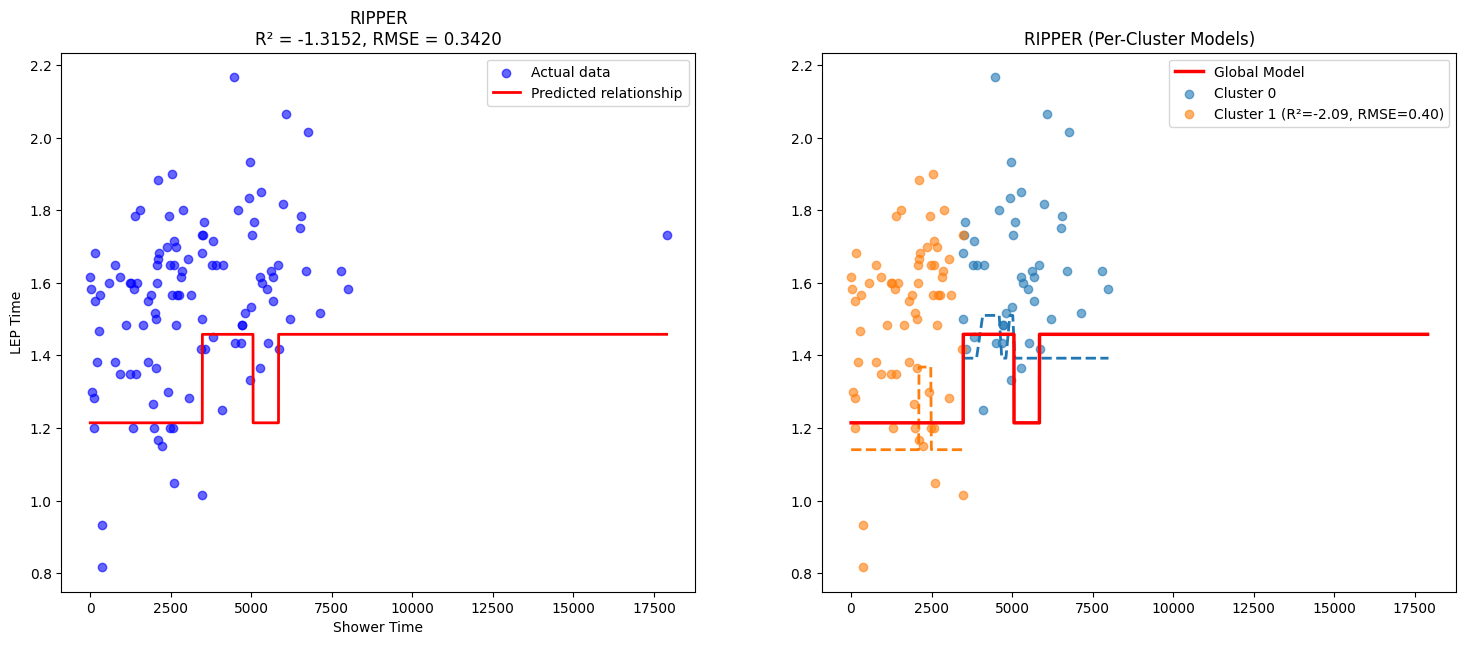

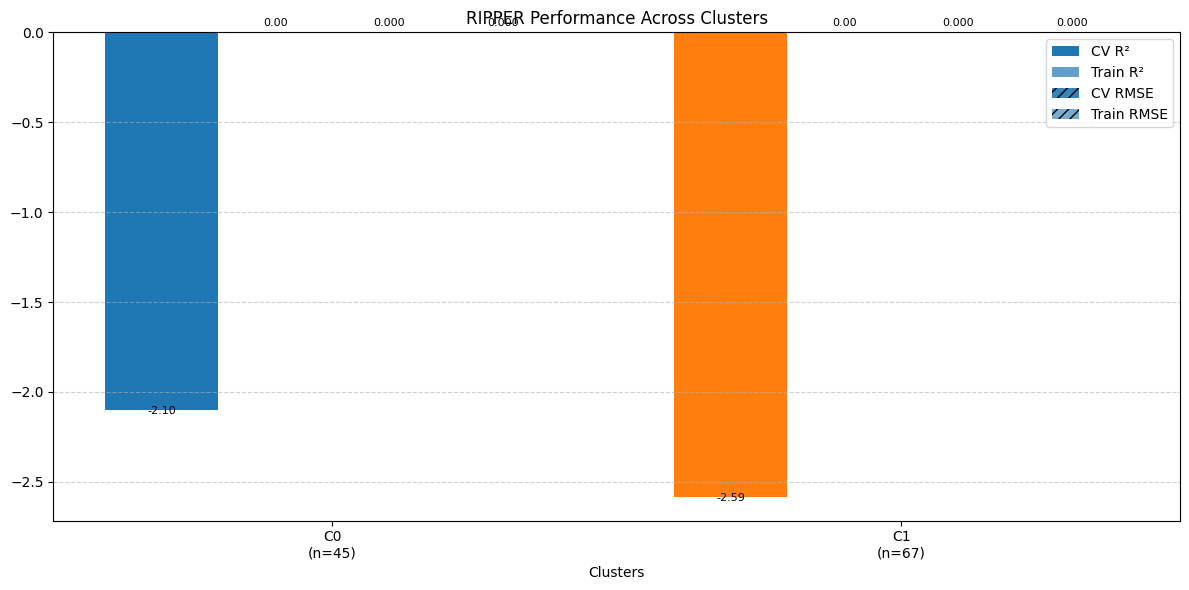

<Figure size 640x480 with 0 Axes>

Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [ ]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_ripper(df, c1, c2)

# Clustering


--- Analyzing exercise:fitbit:steps vs night:yasa:adjusted:deepSleep with Default Model ---
Removing outliers using 'influence' method...
Windsorizing: removed 4 points (3.3%) outside of percentile range 0.0050-0.9950
Model-based removal: removed 12 additional points (9.9%), R² improved from 0.0035 to 0.0816
Total removed: 16 points (13.2%)
- 4 points removed by windsorizing (3.3%)
- 12 points removed for model improvement (9.9%)
After outlier removal: 105 data points remaining (16 removed)

Finding clusters in the data...
Using 2D GMM clustering on both exercise:fitbit:steps and night:yasa:adjusted:deepSleep
Finding GMM subsets for Default Model...

--- Default Model Performance within GMM Clusters ---
  GMM - Cluster 0 (Index 0):
    Size: 32 points
    exercise:fitbit:steps range: 3897.00 to 7778.00 (std=869.12)
    night:yasa:adjusted:deepSleep range: 1.37 to 2.02 (std=0.16)
    CV R² Score: -0.1415 (Note: Negative R² indicates model performs worse than predicting the mean)
    Sp

c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:415: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feat2, data=clean_df, ax=ax_box, palette=distinct_colors)
c:\dev\Brainwave-Processor\notebooks\Stats\stats_clustering.py:415: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(x='cluster', y=feat2, data=clean_df, ax=ax_box, palette=distinct_colors)



Tukey HSD Post-hoc Test:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.0008 0.9999 -0.1164 0.1179  False
     0      2   0.1245 0.0563 -0.0026 0.2517  False
     1      2   0.1238 0.0169  0.0185 0.2291   True
---------------------------------------------------


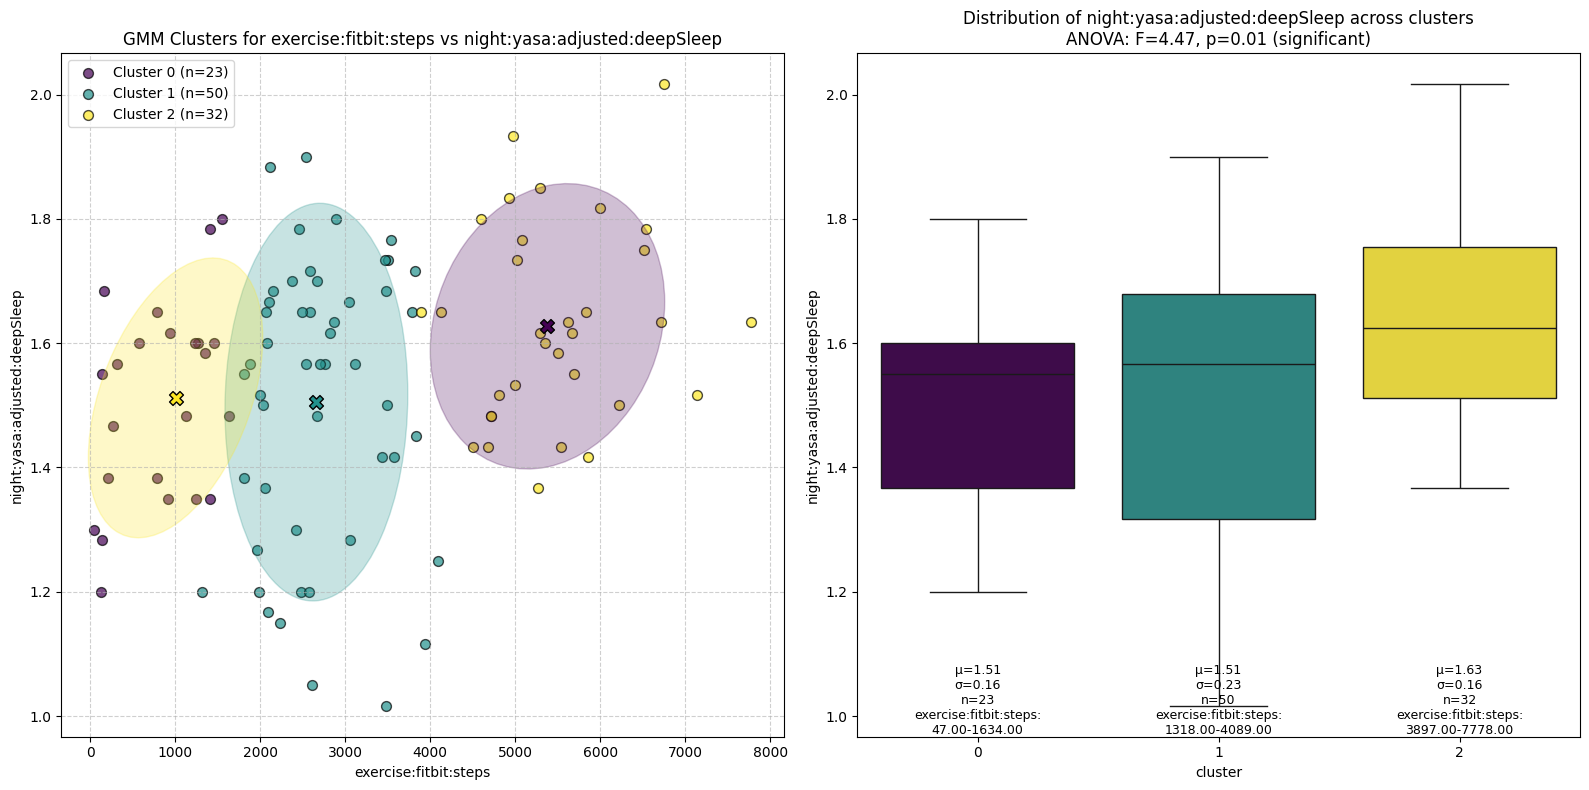

In [59]:
import stats_clustering
reload(stats_clustering)

models = stats_clustering.analyze_clusters_with_anova(df, c1, c2)